# Simple model II ("Udacity")

__Model:__ A simple CNN adapted from the MNIST example available at [TODO]()

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Get dataset

In [ ]:
# Authenticate to GCS.

from google.colab import auth
auth.authenticate_user()

# Copy data set files
!test -f dataset.zip || gsutil cp gs://onboard_image_dataset/dataset.zip .
!unzip -q -o dataset.zip

Copying gs://onboard_image_dataset/dataset.zip...
\ [1 files][183.3 MiB/183.3 MiB]                                                
Operation completed over 1 objects/183.3 MiB.                                    


## Define train, validation and test sets

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_dataset = datagen.flow_from_directory(
    'dataset/train',
    target_size=(64,64),
    class_mode='sparse'
)
validation_dataset = datagen.flow_from_directory(
    'dataset/validation',
    target_size=(64,64),
    class_mode='sparse'
)
test_dataset = datagen.flow_from_directory(
    'dataset/test',
    target_size=(64,64),
    class_mode='sparse'
)

Found 630 images belonging to 3 classes.
Found 135 images belonging to 3 classes.
Found 135 images belonging to 3 classes.



## Define CNN using Keras API


In [ ]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

## Train model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

max_epochs = 50

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
     train_dataset,
     epochs=max_epochs,
     validation_data=validation_dataset,
     callbacks = [stop_early]
)

Epoch 1/50
20/20 [==============================] - 43s 791ms/step - loss: 1.0813 - accuracy: 0.4397 - val_loss: 1.0334 - val_accuracy: 0.5556
Epoch 2/50
20/20 [==============================] - 15s 773ms/step - loss: 0.9294 - accuracy: 0.5556 - val_loss: 0.8012 - val_accuracy: 0.6519
Epoch 3/50
20/20 [==============================] - 15s 779ms/step - loss: 0.7341 - accuracy: 0.6873 - val_loss: 0.6862 - val_accuracy: 0.7407
Epoch 4/50
20/20 [==============================] - 15s 778ms/step - loss: 0.6241 - accuracy: 0.7365 - val_loss: 0.6225 - val_accuracy: 0.6963
Epoch 5/50
20/20 [==============================] - 15s 771ms/step - loss: 0.5474 - accuracy: 0.7778 - val_loss: 0.6165 - val_accuracy: 0.7333
Epoch 6/50
20/20 [==============================] - 15s 774ms/step - loss: 0.5434 - accuracy: 0.8079 - val_loss: 0.5915 - val_accuracy: 0.7852
Epoch 7/50
20/20 [==============================] - 15s 774ms/step - loss: 0.5663 - accuracy: 0.7460 - val_loss: 0.6462 - val_accuracy: 0.7037

## Plot training evolution

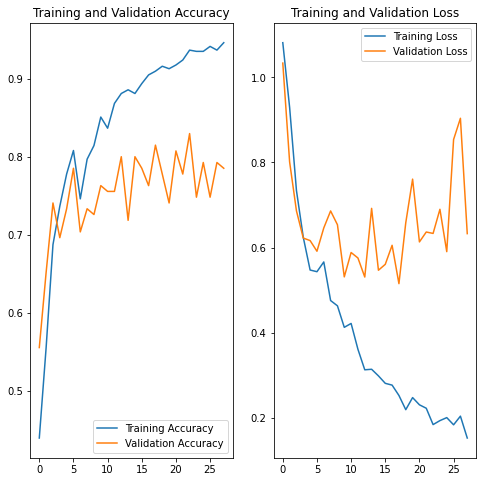

In [ ]:
from  matplotlib import pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Save model and convert it to TFLite format

In [ ]:
model.save('udacity')
converter = tf.lite.TFLiteConverter.from_saved_model('udacity') # path to the SavedModel directory
tflite_model = converter.convert()
with open('udacity.tflite', 'wb') as f:
      f.write(tflite_model)

INFO:tensorflow:Assets written to: udacity/assets


## Calculate accuracy and loss for validation and test datasets

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)

print("VALIDATION - loss {}, accuracy {}".format(loss,accuracy))

loss, accuracy = model.evaluate(test_dataset)

print("TEST - loss {}, accuracy {}".format(loss,accuracy))

5/5 [==============================] - 3s 533ms/step - loss: 0.5153 - accuracy: 0.8148
VALIDATION - loss 0.5153446793556213, accuracy 0.8148148059844971
5/5 [==============================] - 3s 524ms/step - loss: 0.3569 - accuracy: 0.8593
TEST - loss 0.35689589381217957, accuracy 0.8592592477798462
